### iris multi classification
- data: '../../EX_ML/data/iris.csv'
- feature: sapal.lenth, sapal.width, petal.length, petal.width
- label: veriety


- multi classification model base on DNN
---
- dataset: '../../EX_ML/data/iris.csv
- feature: sepal.length, sepal.width, petal.length, petal.width
- label: veriety
- learning method: superviesd learning, multi classification
- learning algorithm: ANN
- frame work: Pytorch

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optima
from torch.utils.data import Dataset, DataLoader

from torchmetrics.classification import F1Score
from torchinfo import summary

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# random_state: 16
torch.manual_seed(16)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print('-- Notice --')
print(f'decvice: {DEVICE}')
print(f'torch ver: {torch.__version__}')
print(f'pandas ver: {pd.__version__}')
print(f'numpy ver: {np.__version__}')


-- Notice --
decvice: cpu
torch ver: 2.4.1
pandas ver: 2.0.3
numpy ver: 1.24.3


In [3]:
FILE_PATH = '../../EX_ML/data/iris.csv'

iris_df = pd.read_csv(FILE_PATH)
iris_df.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


- model class
---
- `class perpose: iris data learning & multi classification`
- class name: IrisMCModel
- parents class: nn.Module
- parameter: None
- attiribute field: undetermind
- class function: create model structure, forward learning model
- `class structure`
    - input layer: input 4, output 10, activation function: sigmoid or ReLU or LeakyReLU
    - hidden layer: input 10, output 5, activation function: sigmoid or ReLU or LeakyReLU
    - output layer: input 5, output 3, activation function: None <-- nn.CrossEntropyLoss() automatic computing

In [62]:
class IrisMCModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        # functional method
        self.input_layer = nn.Linear(4, 10)
        self.hidden_layer = nn.Linear(10, 5)
        self.output_layer = nn.Linear(5, 3)
        
        # class method
        # self.input_layer = nn.Sequential(nn.Linear(3, 20),
        #                                 nn.ReLU())
        # self.hidden_layer = nn.Sequential(nn.Linear(20, 10),
        #                                   nn.ReLU())
        
    
    def forward(self, X):
        
        # functional method
        y = F.relu(self.input_layer(X))
        y = F.relu(self.hidden_layer(y))
        y = self.output_layer(y)        # nn.CrossEntropyLoss가 알아서계산
        
        # class method
        # y = self.input_layer(X)
        # y = self.hidden_layer(y)
        # y = self.output_layer(y)
        
        return y

- dataset class
---
- dataset: '../../EX_ML/data/iris.csv'
- parents class: torch.utils.data.Dataset
- `class name: IrisDataset`
- feature: sepal.length, sepal.width, petal.lenrth, petal.width
- label: veriety
- parameter: data_df
- attirbute flied: feature_df, label_df, X_train_df, X_val_ts, y_train_df, y_val_ts, n_rows, features, n_features, labels, n_labels
- class function: create dataset structure, length dataset, get dataset batch size
- `class structure`
    - __ init __(self)
    - __ len __(self)
    - __ getitem __(self)

In [63]:
class IrisDataSet(Dataset):
    def __init__(self, data_df):
        super().__init__()
        self.data_df = data_df

        self.feature_df = self.data_df[self.data_df.columns[:-1]]
        label_sr = self.data_df['variety']
        self.label_df = pd.get_dummies(label_sr).astype('int64')    # one-hot encoding
        
        # random_state: 16
        # stratify: self.label_df
        # train : val = 8 : 2
        X_train, X_val, y_train, y_val = train_test_split(self.feature_df, self.label_df, random_state=16, test_size=0.2, stratify=self.label_df)
        scaler = StandardScaler()
        scaler.fit(X_train, y_train)
        X_train = scaler.transform(X_train)
        X_val = scaler.transform(X_val)
        
        self.X_train_df = X_train
        self.X_val_ts = torch.FloatTensor(X_val)
        self.y_train_df = y_train
        self.y_val_ts = torch.FloatTensor(y_val.values)
        
        self.n_rows = self.X_train_df.shape[0]
        self.features = self.feature_df.columns
        self.n_features = self.feature_df.shape[1]
        self.labels = self.data_df[self.data_df.columns[-1]].unique()
        self.n_labels = len(self.labels)
        
    def __len__(self):
        return self.n_rows
    
    def __getitem__(self, idx):
        
        X_train_ts = torch.FloatTensor(self.X_train_df[idx])
        y_train_ts = torch.FloatTensor(self.y_train_df.iloc[idx].values)
        
        return X_train_ts, y_train_ts      

- prepare learning model
---
- learning count: EPOCHS [10, 50, 100]
- learning rate: lr [0.001, 0.01, 0.1]
- batch size: BATCH_SIZE [16, 32, 64]
- data location: DEVICE

- validation & test function
---
- function name: testing
- parameter: model, x, y
- function return: loss, score
- `must not update weight & bais`

In [47]:
def testing(model, X_ts, y_ts):
    with torch.no_grad():
        
        pred = model(X_ts)
        
        loss = nn.CrossEntropyLoss()(pred, y_ts)
        
        score = F1Score(task='multilabel', num_labels=3, num_classes=3)(pred, y_ts)
    
    return loss, score

- model learning
---
- function name: training
- parameter: model, epochs, lr, batch_size, dataset
- function return: loss, score

In [71]:
def tarining(dataset, model, epochs, lr, batch):
    train_val_loss = {'train':[], 'val':[]}
    train_val_score = {'train':[], 'val':[]}
    optmizer = optima.Adam(model.parameters(), lr=lr)
    data_dl = DataLoader(dataset, batch_size=batch)
    
    for epoch in range(1, epochs+1):
        total_train_loss, total_train_score = 0, 0
        
        for X_train, y_train in data_dl:
            batch_cnt = dataset.n_rows / batch
            
            pred = model(X_train)
            
            loss = nn.CrossEntropyLoss()(pred, y_train)
            total_train_loss += loss
            
            score = F1Score(task='multilabel', num_classes=3,  num_labels= 3)(pred, y_train)
            total_train_score += score
            
            # # 디버그...
            # print("\n\n-- 디버그 .. --")
            # print(f"pred vlaue: {pred}")
            # print(f"loss vlaue: {loss}")
            # print(f"score vlaue: {score}\n\n")
            
            optmizer.zero_grad()
            loss.backward()
            optmizer.step()
        
        X_val, y_val = dataset.X_val_ts, dataset.y_val_ts
        val_loss, val_score = testing(model, X_val, y_val)
        
        
        loss_train = (total_train_loss/batch_cnt).item()
        score_train = (total_train_score/batch_cnt).item()
        
        train_val_loss['train'].append(loss_train)
        train_val_score['train'].append(score_train)
        train_val_loss['val'].append(val_loss.item())
        train_val_score['val'].append(val_score.item())
        
        if epoch%5 == 0:
            print(f"[{epoch:5}/{epochs:5}]  [Train] loss: {loss_train:.6f}, score: {score_train:.6f}")
            print(f"[{epoch:5}/{epochs:5}]  [Test]  loss: {val_loss.item():.6f}, score: {val_score.item():.6f}\n")
            
        # print(f"[{epoch:5}/{epochs:5}]  [Train]      loss: {loss_train:.6f}, score: {score_train:.6f}")
        # print(f"[{epoch:5}/{epochs:5}]  [Validation] loss: {val_loss.item():.6f}, score: {val_score.item():.6f}\n")
        
    return train_val_loss, train_val_score

In [82]:
iris_ds = IrisDataSet(iris_df)
iris_mc_model = IrisMCModel()

# iris_ds.labels, iris_ds.n_labels
# iris_ds.label_df

print(iris_mc_model)
summary(iris_mc_model)

IrisMCModel(
  (input_layer): Linear(in_features=4, out_features=10, bias=True)
  (hidden_layer): Linear(in_features=10, out_features=5, bias=True)
  (output_layer): Linear(in_features=5, out_features=3, bias=True)
)


Layer (type:depth-idx)                   Param #
IrisMCModel                              --
├─Linear: 1-1                            50
├─Linear: 1-2                            55
├─Linear: 1-3                            18
Total params: 123
Trainable params: 123
Non-trainable params: 0

In [83]:
# dataset, model, epochs, lr, batch
# dataset: iris_ds
# model: iris_mc_model
# epochs: 10
# learning rate: 0.01
# batch: 10

loss_dict, score_dict = tarining(iris_ds, iris_mc_model, 15, 0.01, 10)

[    5/   15]  [Train] loss: 0.433082, score: 0.896165
[    5/   15]  [Test]  loss: 0.400549, score: 0.909091

[   10/   15]  [Train] loss: 0.207753, score: 0.949856
[   10/   15]  [Test]  loss: 0.170570, score: 0.967742

[   15/   15]  [Train] loss: 0.130827, score: 0.961039
[   15/   15]  [Test]  loss: 0.111513, score: 0.967742



In [110]:
def draw_two_plot(loss, r2, title):
    
    # 축을 2개 사용하고 싶음.
    fig, ax1 = plt.subplots(figsize=(7, 7))
    ax2 = ax1.twinx()
    
    ax1.plot(loss['train'], label=f"train loss mean: {sum(loss['train'])/len(loss['train']):.6f}", color='#5587ED')
    ax1.plot(loss['val'], label=f"test loss mean: {sum(loss['val'])/len(loss['val']):.6f}", color='#F361A6')
    ax2.plot(r2['train'], label=f"train score max: {max(r2['train'])*100:.2f} %", color='#00007F')
    ax2.plot(r2['val'], label=f"test score max: {max(r2['val'])*100:.2f} %", color='#99004C')
    
    fig.suptitle(f'{title} iris ANN multi classification', fontsize=15)
    ax1.set_ylabel('loss', fontsize=10, color='#5587ED')
    ax2.set_ylabel('score', fontsize=10, color='#00007F')
    
    fig.legend(fontsize='small', loc='lower left')
    plt.xticks(np.arange(0, len(loss['train']), 2), labels=[x for x in range(1, len(loss['val'])+1, 2)])
    plt.show()

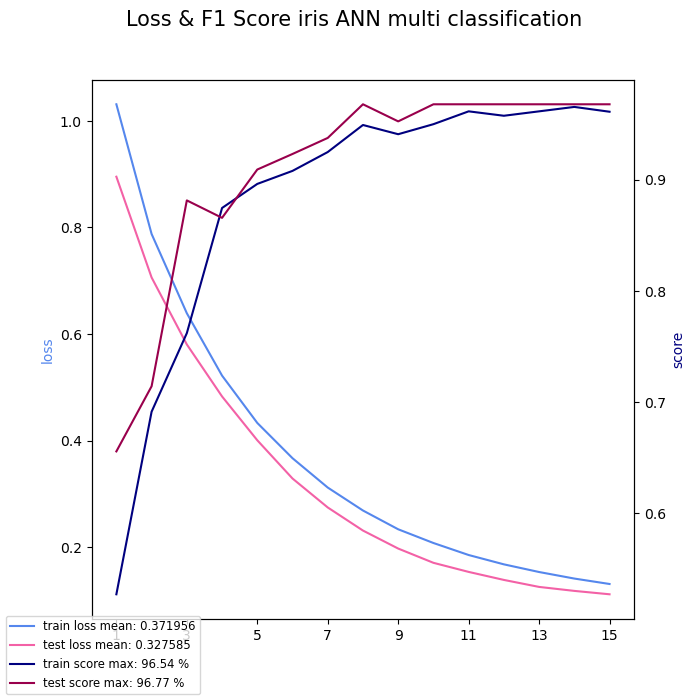

In [111]:
draw_two_plot(loss_dict, score_dict, 'Loss & F1 Score')